### XGBoost

In [1]:
%matplotlib inline
from utils import *
import xgboost as xgb
from time import time

Using Theano backend.
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
act_train_data = pd.read_csv("./act_train.csv", 
                             dtype={'people_id': np.str, 'activity_id': np.str, 'outcome': np.int8}, 
                             parse_dates=['date'])
act_test_data  = pd.read_csv("./act_test.csv", 
                             dtype={'people_id': np.str, 'activity_id': np.str}, parse_dates=['date'])
people_data    = pd.read_csv("./people.csv", 
                             dtype={'people_id': np.str, 'activity_id': np.str, 'char_38': np.int32}, 
                             parse_dates=['date'])

In [3]:
act_train_data[:3]

,people_id,activity_id,date,activity_category,char_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10,outcome
0,ppl_100,act2_1734928,2023-08-26,type 4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 76,0
1,ppl_100,act2_2434093,2022-09-27,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,0
2,ppl_100,act2_3404049,2022-09-27,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,0


In [4]:
act_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2197291 entries, 0 to 2197290
Data columns (total 15 columns):
people_id            object
activity_id          object
date                 datetime64[ns]
activity_category    object
char_1               object
char_2               object
char_3               object
char_4               object
char_5               object
char_6               object
char_7               object
char_8               object
char_9               object
char_10              object
outcome              int8
dtypes: datetime64[ns](1), int8(1), object(13)
memory usage: 236.8+ MB


In [5]:
people_data[:3]

,people_id,char_1,group_1,char_2,date,char_3,char_4,char_5,char_6,char_7,...,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38
0,ppl_100,type 2,group 17304,type 2,2021-06-29,type 5,type 5,type 5,type 3,type 11,...,False,True,True,False,False,True,True,True,False,36
1,ppl_100002,type 2,group 8688,type 3,2021-01-06,type 28,type 9,type 5,type 3,type 11,...,False,True,True,True,True,True,True,True,False,76
2,ppl_100003,type 2,group 33592,type 3,2022-06-10,type 4,type 8,type 5,type 2,type 5,...,False,False,True,True,True,True,False,True,True,99


In [6]:
people_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189118 entries, 0 to 189117
Data columns (total 41 columns):
people_id    189118 non-null object
char_1       189118 non-null object
group_1      189118 non-null object
char_2       189118 non-null object
date         189118 non-null datetime64[ns]
char_3       189118 non-null object
char_4       189118 non-null object
char_5       189118 non-null object
char_6       189118 non-null object
char_7       189118 non-null object
char_8       189118 non-null object
char_9       189118 non-null object
char_10      189118 non-null bool
char_11      189118 non-null bool
char_12      189118 non-null bool
char_13      189118 non-null bool
char_14      189118 non-null bool
char_15      189118 non-null bool
char_16      189118 non-null bool
char_17      189118 non-null bool
char_18      189118 non-null bool
char_19      189118 non-null bool
char_20      189118 non-null bool
char_21      189118 non-null bool
char_22      189118 non-null bool
char_23

In [7]:
print("Train data shape: " + format(act_train_data.shape))
print("Test data shape: " + format(act_test_data.shape))
print("People data shape: " + format(people_data.shape))

Train data shape: (2197291, 15)
Test data shape: (498687, 14)
People data shape: (189118, 41)


In [3]:
def reduce_dim(dataset, column):
    # collect those showing only once to one category
    for index, dup in dataset[column].duplicated(keep=False).iteritems():
        if not dup:
            dataset.set_value(index, column, -1)
    # collect categories showing below four times to one category
    #category_count = dataset.groupby(column)[column].count()
    #try:
    #    dataset[column].replace(category_count[category_count<4].index, -1, inplace=True)
    #except:
    #    pass
    
    # re-index
    new_index = {idx:i for i, idx in enumerate(dataset[column].unique())}
    dataset[column] = dataset[column].apply(lambda x: new_index[x])
    return dataset
    
def act_data_treatment(dataset):
    for col in list(dataset.columns):
        if col not in ['people_id', 'activity_id', 'date', 'char_38', 'outcome']:
            if dataset[col].dtype == 'object':
                # regard NA as a category
                dataset[col].fillna('type 0', inplace=True)
                dataset[col] = dataset[col].apply(lambda x: x.split(' ')[1]).astype(np.int32)
            elif dataset[col].dtype == 'bool':
                # change binary feature to type int (0/1)
                dataset[col] = dataset[col].astype(np.int8)
    
    dataset['year'] = dataset['date'].dt.year
    dataset['month'] = dataset['date'].dt.month
    dataset['day'] = dataset['date'].dt.day
    dataset['isweekend'] = (dataset['date'].dt.weekday >= 5).astype('int8')
    dataset = dataset.drop('date', axis=1)
    
    return dataset

In [4]:
act_train_data = act_train_data.drop('char_10', axis=1)
act_test_data = act_test_data.drop('char_10', axis=1)

print("Train data shape: " + format(act_train_data.shape))
print("Test data shape: " + format(act_test_data.shape))
print("People data shape: " + format(people_data.shape))

Train data shape: (2197291, 14)
Test data shape: (498687, 13)
People data shape: (189118, 41)


In [5]:
%%time
act_train_data = act_data_treatment(act_train_data)
act_test_data  = act_data_treatment(act_test_data)
people_data    = act_data_treatment(people_data)

CPU times: user 32.8 s, sys: 2.14 s, total: 34.9 s
Wall time: 34.8 s


In [6]:
train = act_train_data.merge(people_data, on='people_id', how='left')
test  = act_test_data.merge(people_data, on='people_id', how='left')
act_id = act_test_data['activity_id']

del act_train_data, act_test_data, people_data
print("Train data shape: " + format(train.shape))
print("Test data shape: " + format(test.shape))

Train data shape: (2197291, 60)
Test data shape: (498687, 59)


In [8]:
{col:train[col].nunique() for col in train.columns}

{'activity_category': 7,
 'activity_id': 2197291,
 'char_10': 2,
 'char_11': 2,
 'char_12': 2,
 'char_13': 2,
 'char_14': 2,
 'char_15': 2,
 'char_16': 2,
 'char_17': 2,
 'char_18': 2,
 'char_19': 2,
 'char_1_x': 52,
 'char_1_y': 2,
 'char_20': 2,
 'char_21': 2,
 'char_22': 2,
 'char_23': 2,
 'char_24': 2,
 'char_25': 2,
 'char_26': 2,
 'char_27': 2,
 'char_28': 2,
 'char_29': 2,
 'char_2_x': 33,
 'char_2_y': 3,
 'char_30': 2,
 'char_31': 2,
 'char_32': 2,
 'char_33': 2,
 'char_34': 2,
 'char_35': 2,
 'char_36': 2,
 'char_37': 2,
 'char_38': 101,
 'char_3_x': 12,
 'char_3_y': 43,
 'char_4_x': 8,
 'char_4_y': 25,
 'char_5_x': 8,
 'char_5_y': 9,
 'char_6_x': 6,
 'char_6_y': 7,
 'char_7_x': 9,
 'char_7_y': 25,
 'char_8_x': 19,
 'char_8_y': 8,
 'char_9_x': 20,
 'char_9_y': 9,
 'day_x': 31,
 'day_y': 31,
 'group_1': 29899,
 'isweekend_x': 2,
 'isweekend_y': 2,
 'month_x': 12,
 'month_y': 12,
 'outcome': 2,
 'people_id': 151295,
 'year_x': 2,
 'year_y': 4}

------------------------------------------------------------

Explore 'people_id' and 'group_1'

In [8]:
train['people_id'].nunique()

151295

In [14]:
people_count = train.groupby('people_id')['outcome'].count().sort_values(ascending=False)
people_count.name = 'count'
people_mean = train.groupby('people_id')['outcome'].mean()
people_mean.name = 'outcome_mean'
people_attr = pd.concat([people_count, people_mean], axis=1)
people_attr.sort_values('count', axis=0, ascending=False, inplace=True)
people_attr

,count,outcome_mean
ppl_294918,55103,0.000000
ppl_370270,53668,0.000224
ppl_105739,45936,0.000000
ppl_54699,23969,0.000000
ppl_64887,7052,0.999858
ppl_250020,4293,0.000000
ppl_351668,3144,0.000000
ppl_36839,3059,0.000000
ppl_372923,2365,0.000000
ppl_265578,1539,0.000000


In [10]:
test['people_id'].nunique()

22321

In [11]:
test.groupby('people_id')['people_id'].count().sort_values(ascending=False)

people_id
ppl_137922    868
ppl_60553     532
ppl_306851    490
ppl_162444    482
ppl_299382    477
ppl_241764    416
ppl_215180    388
ppl_21749     387
ppl_96319     383
ppl_25870     375
ppl_50312     372
ppl_170054    371
ppl_73780     367
ppl_308274    361
ppl_173480    345
ppl_27897     339
ppl_31903     333
ppl_348071    333
ppl_351655    333
ppl_261554    329
ppl_139851    322
ppl_161560    321
ppl_359319    318
ppl_118951    316
ppl_337695    298
ppl_113743    297
ppl_369229    296
ppl_211414    292
ppl_308743    290
ppl_351749    288
             ... 
ppl_30373       1
ppl_303830      1
ppl_153547      1
ppl_153508      1
ppl_1535        1
ppl_30395       1
ppl_153478      1
ppl_304085      1
ppl_153459      1
ppl_304088      1
ppl_304272      1
ppl_153411      1
ppl_304416      1
ppl_304446      1
ppl_153148      1
ppl_304634      1
ppl_153099      1
ppl_304704      1
ppl_304775      1
ppl_153078      1
ppl_304882      1
ppl_3050        1
ppl_305041      1
ppl_152876      1


In [12]:
group_count = train.groupby('group_1')['outcome'].count()
group_count.name = 'count'
group_mean = train.groupby('group_1')['outcome'].mean()
group_mean.name = 'outcome_mean'
group_attr = pd.concat([group_count, group_mean], axis=1)
group_attr.sort_values('count', axis=0, ascending=False, inplace=True)
group_attr

,count,outcome_mean
group_1,,
17304,799125,0.000000
27940,53668,0.000224
667,15865,1.000000
8386,7929,1.000000
20472,7053,0.999858
9280,5492,1.000000
17899,4767,1.000000
450,3867,1.000000
7256,3759,1.000000


------------------------------------------------------------

#### reduce the dimension of each categorical features

In [15]:
whole = pd.concat([train, test], ignore_index=True)
categorical = ['group_1', 'activity_category', 'char_1_x', 'char_2_x', 'char_3_x', 'char_4_x', 'char_5_x', 
               'char_6_x', 'char_7_x', 'char_8_x', 'char_9_x', 'char_2_y', 'char_3_y', 'char_4_y', 'char_5_y',
               'char_6_y', 'char_7_y', 'char_8_y', 'char_9_y']
t0 = time()
for category in categorical:
    whole = reduce_dim(whole, category)
print "Elapsed time %.2f seconds for cleaning categorical features." %(time()-t0)

X = whole[:(len(train))]
X_test = whole[len(train):len(train)+len(test)]

print("Train data shape: " + format(X.shape))
print("Test data shape: " + format(X_test.shape))
del train, test, whole

Elapsed time 44.00 seconds for cleaning categorical features.
Train data shape: (2197291, 60)
Test data shape: (498687, 60)


In [16]:
X_test = X_test.drop('outcome', axis=1)
X['outcome'].mean()

0.44395439657287089

#### train/validation data split

In [19]:
%%time
# cross validation split by people_id
nb_folds = 6
sample_per_fold = X.shape[0] // nb_folds
# unstratified split for cv
np.random.seed(0)
val_ppls = []
ppls = X['people_id'].unique()
for i in range(nb_folds-1):
    # create valid set people_id
    print("collecting set %d..." %(i+1))
    val_people_id2num = {}
    nb_val = 0
    while nb_val < sample_per_fold:
        p_id = np.random.choice(ppls,1)[0]
        if p_id not in val_people_id2num:
            val_people_id2num[p_id] = people_count[p_id]
            nb_val += val_people_id2num[p_id]
    val_ppls.append(val_people_id2num.keys())
    ppls = np.array(list(set(ppls) - set(val_ppls[i])))

print("collecting set {}...".format(nb_folds))
val_ppls.append(ppls)

train_indices = []
valid_indices = []
for i in range(len(val_ppls)):
    valid_indices.append(np.where(X['people_id'].isin(val_ppls[i]))[0])
    tr_idx = np.array([])
    for j in set(range(len(val_ppls)))-{i}:
        tr_idx = np.concatenate([tr_idx, np.where(X['people_id'].isin(val_ppls[j]))[0]])
    tr_idx.sort()
    train_indices.append(tr_idx.astype('int'))

collecting set 1...
collecting set 2...
collecting set 3...
collecting set 4...
collecting set 5...
collecting set 6...
CPU times: user 10.3 s, sys: 340 ms, total: 10.7 s
Wall time: 10.8 s


In [20]:
not_categorical = list(set(X.columns)-set(categorical)-{'activity_id', 'people_id', 'outcome'})

### Linear function based

In [21]:
from sklearn.preprocessing import OneHotEncoder

print "One-hot encoding and transforming to sparse..."
t0 = time()
enc = OneHotEncoder(handle_unknown='ignore')
enc = enc.fit(pd.concat([X[categorical], X_test[categorical]]))
X_test_cat_sparse = enc.transform(X_test[categorical])

from scipy.sparse import hstack
X_test_sparse = hstack((X_test[not_categorical], X_test_cat_sparse))
print "Elapsed time: %.2f seconds." %(time()-t0)

print("Test data: " + format(X_test_sparse.shape))
del X_test_cat_sparse

One-hot encoding and transforming to sparse...
Elapsed time: 15.22 seconds.
Test data: (498687, 31271)


In [22]:
%%time
print "Transforming to DMatrix..."
dtest = xgb.DMatrix(X_test_sparse)
del X_test_sparse

Transforming to DMatrix...
CPU times: user 12.9 s, sys: 1.57 s, total: 14.4 s
Wall time: 14.6 s


training with diversity from split by people_id and random seed

In [15]:
%%time
preds_val = []
ys_val = []
preds_test = []
for i in range(nb_folds):
    print("\nTransforming data to sparse...")
    X_tr = X.iloc[train_indices[i]]
    X_val = X.iloc[valid_indices[i]]
    y_tr, y_val = X_tr['outcome'], X_val['outcome']
    ys_val.append(y_val)
    
    X_cat_sparse = enc.transform(X_tr[categorical])
    X_val_cat_sparse = enc.transform(X_val[categorical])
    X_sparse = hstack((X_tr[not_categorical], X_cat_sparse))
    X_val_sparse = hstack((X_val[not_categorical], X_val_cat_sparse))
    
    print("Training data: " + format(X_sparse.shape))
    print("Validating data: " + format(X_val_sparse.shape))
    del X_tr, X_val, X_cat_sparse, X_val_cat_sparse
    
    print("Training fold %d..." %(i+1))
    print("DMatrix initialing...")
    t0 = time()
    dtrain = xgb.DMatrix(X_sparse, label=y_tr)
    dval = xgb.DMatrix(X_val_sparse, label=y_val)
    print("Elapsed time: %.2f seconds." %(time()-t0))
    del X_sparse, X_val_sparse
    
    seed = np.random.randint(100)
    param = {'nthread':4, 'silent':1, 'objective':'binary:logistic', 'eval_metric':'auc', 
             'eta':0.2, 'alpha':0., 'lambda':0.2, 'booster':'gblinear', 'seed':seed}
    early_stopping_rounds = 3
    num_round = 100
    watchlist  = [(dtrain,'train'), (dval,'validation')]
    
    bst = xgb.train(param, dtrain, num_round, watchlist, early_stopping_rounds=early_stopping_rounds)
    preds_val.append(bst.predict(dval))
    preds_test.append(bst.predict(dtest))


Transforming data to sparse...
Training data: (1831072, 31271)
Validating data: (366219, 31271)
Training fold 1...
DMatrix initialing...
Elapsed time: 98.18 seconds.
[0]	train-auc:0.952138	validation-auc:0.928913
Multiple eval metrics have been passed: 'validation-auc' will be used for early stopping.

Will train until validation-auc hasn't improved in 3 rounds.
[1]	train-auc:0.984441	validation-auc:0.955007
[2]	train-auc:0.99153	validation-auc:0.964831
[3]	train-auc:0.993975	validation-auc:0.969236
[4]	train-auc:0.995199	validation-auc:0.971463
[5]	train-auc:0.995908	validation-auc:0.972705
[6]	train-auc:0.996337	validation-auc:0.973004
[7]	train-auc:0.996611	validation-auc:0.97335
[8]	train-auc:0.996791	validation-auc:0.973278
[9]	train-auc:0.996908	validation-auc:0.973226
[10]	train-auc:0.996984	validation-auc:0.973165
Stopping. Best iteration:
[7]	train-auc:0.996611	validation-auc:0.97335


Transforming data to sparse...
Training data: (1831076, 31271)
Validating data: (366215, 31

[30]	train-auc:0.997216	validation-auc:0.980426
[31]	train-auc:0.997217	validation-auc:0.98043
[32]	train-auc:0.997218	validation-auc:0.980434
[33]	train-auc:0.997219	validation-auc:0.980439
[34]	train-auc:0.99722	validation-auc:0.980444
[35]	train-auc:0.997221	validation-auc:0.980448
[36]	train-auc:0.997222	validation-auc:0.980452
[37]	train-auc:0.997223	validation-auc:0.980456
[38]	train-auc:0.997223	validation-auc:0.980459
[39]	train-auc:0.997224	validation-auc:0.980461
[40]	train-auc:0.997225	validation-auc:0.980464
[41]	train-auc:0.997225	validation-auc:0.980466
[42]	train-auc:0.997226	validation-auc:0.980468
[43]	train-auc:0.997226	validation-auc:0.980469
[44]	train-auc:0.997227	validation-auc:0.980471
[45]	train-auc:0.997228	validation-auc:0.980472
[46]	train-auc:0.997228	validation-auc:0.980473
[47]	train-auc:0.997229	validation-auc:0.980474
[48]	train-auc:0.997229	validation-auc:0.980475
[49]	train-auc:0.997229	validation-auc:0.980475
[50]	train-auc:0.99723	validation-auc:0.98

In [16]:
from sklearn.metrics import roc_auc_score
[roc_auc_score(ys_val[i], preds_val[i]) for i in range(nb_folds)], np.mean([roc_auc_score(ys_val[i], preds_val[i]) for i in range(nb_folds)])

([0.97316476063163515,
  0.980974343824772,
  0.9773649527560957,
  0.98047525942419023,
  0.97814518230229663,
  0.98754211940930525],
 0.9796111030580491)

In [17]:
pred_test = np.mean(preds_test, 0)
submit = pd.DataFrame({ 'activity_id': act_id, 'outcome': pred_test })
submit.to_csv('eval_gbl_ppl_mix.csv', index=False)

In [17]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

pred_val = bst.predict(dval)
val_score = roc_auc_score(y_val, pred_val)
fpr, tpr, thresholds = roc_curve(y_val, pred_val)

In [18]:
print('validation accuracy: %.4f%%' % (np.mean((pred_val>=0.5).astype(int) == y_val)*100))
print('validation auc score: %.4f' % val_score)

validation accuracy: 93.2378%
validation auc score: 0.9875


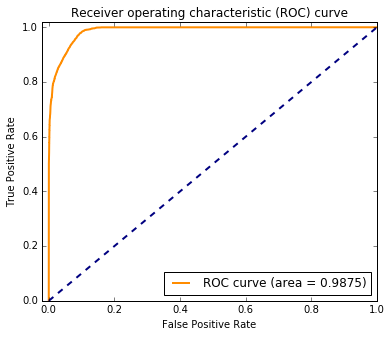

In [22]:
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.4f)' % val_score)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
#plt.axis('tight')
plt.show()

[[219712  18740]
 [  6019 121667]]


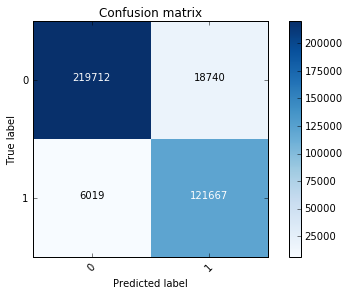

In [23]:
cm = confusion_matrix(y_val, (pred_val>=0.5).astype(int))
plot_confusion_matrix(cm, [0,1])

[[ 0.6001  0.0512]
 [ 0.0164  0.3323]]


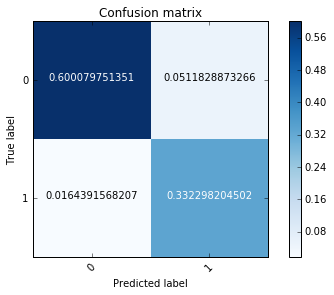

In [24]:
plot_confusion_matrix(cm / float(len(y_val)), [0,1])

### Tree-based

With no one-hot encoding

In [25]:
%%time
print "XGBoost initialing..."
dtest = xgb.DMatrix(X_test.drop(['activity_id', 'people_id'], axis=1))

XGBoost initialing...
CPU times: user 745 ms, sys: 1.18 s, total: 1.92 s
Wall time: 2.47 s


In [28]:
%%time
preds_val = []
ys_val = []
preds_test = []
for i in range(nb_folds):
    print("\nTrain/val splitting...")
    X_tr = X.iloc[train_indices[i]]
    X_val = X.iloc[valid_indices[i]]
    y_tr, y_val = X_tr['outcome'], X_val['outcome']
    ys_val.append(y_val)
    
    print("Training fold %d..." %(i+1))
    print("DMatrix initialing...")
    t0 = time()
    X_tr = X_tr.drop(['activity_id', 'people_id', 'outcome'], axis=1)
    X_val = X_val.drop(['activity_id', 'people_id', 'outcome'], axis=1)
    dtrain = xgb.DMatrix(X_tr, label=y_tr)
    dval = xgb.DMatrix(X_val, label=y_val)
    print("Elapsed time: %.2f seconds." %(time()-t0))
    del X_tr, X_val
    
    seed = np.random.randint(100)
    param = {'nthread':4, 'silent':1, 'objective':'binary:logistic', 'eval_metric':'auc', 'booster':'gbtree', 
         'eta':0.2, 'max_depth': 8, 'subsample':0.8, 'colsample_bytree':0.5, 'seed':seed} #, 'colsample_bylevel':0.5
    watchlist  = [(dtrain,'train'), (dval,'validation')]
    num_round = 50
    early_stopping_rounds = 5
    
    bst = xgb.train(param, dtrain, num_round, watchlist, early_stopping_rounds=early_stopping_rounds)
    preds_val.append(bst.predict(dval))
    preds_test.append(bst.predict(dtest))


Train/val splitting...
Training fold 1...
DMatrix initialing...
Elapsed time: 15.47 seconds.
[0]	train-auc:0.927567	validation-auc:0.883419
Multiple eval metrics have been passed: 'validation-auc' will be used for early stopping.

Will train until validation-auc hasn't improved in 5 rounds.
[1]	train-auc:0.938191	validation-auc:0.89168
[2]	train-auc:0.935556	validation-auc:0.895112
[3]	train-auc:0.938426	validation-auc:0.919718
[4]	train-auc:0.944775	validation-auc:0.927193
[5]	train-auc:0.945704	validation-auc:0.931377
[6]	train-auc:0.947749	validation-auc:0.931482
[7]	train-auc:0.948129	validation-auc:0.93235
[8]	train-auc:0.95179	validation-auc:0.93575
[9]	train-auc:0.953694	validation-auc:0.937614
[10]	train-auc:0.954601	validation-auc:0.937992
[11]	train-auc:0.955283	validation-auc:0.939434
[12]	train-auc:0.955836	validation-auc:0.938234
[13]	train-auc:0.956745	validation-auc:0.933403
[14]	train-auc:0.957895	validation-auc:0.935992
[15]	train-auc:0.959247	validation-auc:0.935629


[29]	train-auc:0.969891	validation-auc:0.944098
[30]	train-auc:0.970162	validation-auc:0.94437
[31]	train-auc:0.971199	validation-auc:0.944565
[32]	train-auc:0.971454	validation-auc:0.944629
[33]	train-auc:0.971718	validation-auc:0.944856
[34]	train-auc:0.972306	validation-auc:0.945679
[35]	train-auc:0.972615	validation-auc:0.946018
[36]	train-auc:0.973059	validation-auc:0.9461
[37]	train-auc:0.973379	validation-auc:0.946551
[38]	train-auc:0.973592	validation-auc:0.94684
[39]	train-auc:0.973887	validation-auc:0.946979
[40]	train-auc:0.974141	validation-auc:0.947108
[41]	train-auc:0.974495	validation-auc:0.94746
[42]	train-auc:0.974663	validation-auc:0.947593
[43]	train-auc:0.974919	validation-auc:0.947894
[44]	train-auc:0.9752	validation-auc:0.948071
[45]	train-auc:0.97549	validation-auc:0.948322
[46]	train-auc:0.976079	validation-auc:0.948506
[47]	train-auc:0.976512	validation-auc:0.948896
[48]	train-auc:0.976734	validation-auc:0.948784
[49]	train-auc:0.976996	validation-auc:0.948729


In [29]:
[roc_auc_score(ys_val[i], preds_val[i]) for i in range(nb_folds)], np.mean([roc_auc_score(ys_val[i], preds_val[i]) for i in range(nb_folds)])

([0.93306321641714418,
  0.95229288770365483,
  0.93672691465670832,
  0.94872945512707652,
  0.94468865478842678,
  0.96930648094152427],
 0.94746793493908921)

In [30]:
pred_test = np.mean(preds_test, 0)
submit = pd.DataFrame({ 'activity_id': act_id, 'outcome': pred_test })
submit.to_csv('eval_gbt_ppl_mix.csv', index=False)

In [31]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

pred_val = bst.predict(dval)
val_score = roc_auc_score(y_val, pred_val)
fpr, tpr, thresholds = roc_curve(y_val, pred_val)

In [32]:
print('validation accuracy: %.4f%%' % (np.mean((pred_val>=0.5).astype(int) == y_val)*100))
print('validation auc score: %.4f' % val_score)

validation accuracy: 90.4348%
validation auc score: 0.9693


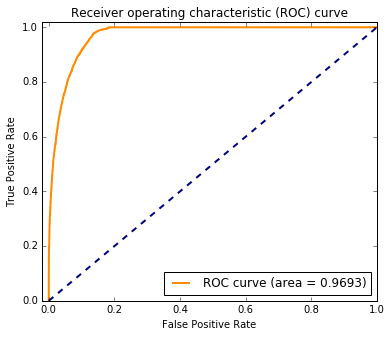

In [33]:
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.4f)' % val_score)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
#plt.axis('tight')
plt.show()

[[211698  26754]
 [  8268 119418]]


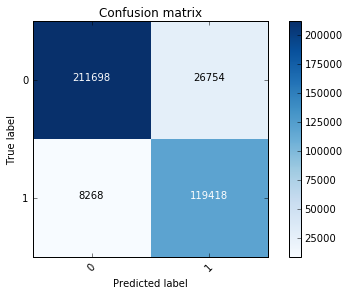

In [34]:
cm = confusion_matrix(y_val, (pred_val>=0.5).astype(int))
plot_confusion_matrix(cm, [0,1])

[[ 0.5782  0.0731]
 [ 0.0226  0.3262]]


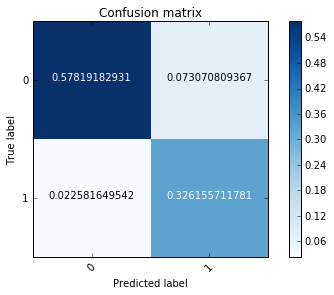

In [35]:
plot_confusion_matrix(cm / float(len(y_val)), [0,1])